In [1]:
import numpy as np
import os
import pathlib
import random
import torch
import pytorch3d.transforms
import torchgeometry
import cv2
from dlclive import DLCLive, Processor

import matplotlib.pyplot as plt
from random import randrange
import random
from IPython.display import clear_output

from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


2023-08-08 17:42:52.174084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aman/opt/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
USE_GPU = True
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()

class ConstrainedTensor(torch.nn.Module):
    def __init__(self, dim1, dim2, init_tensor=None, init_std=0.1, min_val=0.0, max_val=1.0):
        super().__init__()
        self._dim1 = dim1
        self._dim2 = dim2
        if init_tensor is None:
            init_tensor = torch.empty(dim1, dim2).normal_(mean=0.0, std=init_std)
        self.param = torch.nn.Parameter(init_tensor)
        self.min_val = min_val
        self.max_val = max_val

    def forward(self):
        param = self.param
        param = torch.clamp(param, min=self.min_val, max=self.max_val)
        return param

def getLinkInitialLength(linkName):
    linkObject = learnable_robot_model._get_parent_object_of_param(linkName, "trans")
    return linkObject.trans().detach().clone()

def makeLinkLengthLearnable(linkName, value = None):
    linkObject = learnable_robot_model._get_parent_object_of_param(linkName, "trans")
    learnable_robot_model.make_link_param_learnable(
        linkName, 
        "trans", 
        UnconstrainedTensor(dim1 = 1, dim2 = 3, init_tensor = value)
    )
    print(f"Made {linkName} link's length learnable initialized tensor to {value}")

urdf_path = os.path.join("a1.urdf")
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

intialJointAngles = {joint: getLinkInitialLength(joint) for joint in learnable_robot_model.get_link_names()}

for joint in intialJointAngles:
    makeLinkLengthLearnable(joint, intialJointAngles[joint].detach().clone())

Made base link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made trunk link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made imu_link link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made FR_hip link's length learnable initialized tensor to tensor([[ 0.181, -0.047,  0.000]])
Made FR_thigh_shoulder link's length learnable initialized tensor to tensor([[ 0.000, -0.081,  0.000]])
Made FR_thigh link's length learnable initialized tensor to tensor([[ 0.000, -0.084,  0.000]])
Made FR_calf link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FR_foot link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FL_hip link's length learnable initialized tensor to tensor([[0.181, 0.047, 0.000]])
Made FL_thigh_shoulder link's length learnable initialized tensor to tensor([[0.000, 0.081, 0.000]])
Made FL_thigh link's length learnable initialized tensor to tensor([[0.000, 0.084, 0.00

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [4]:
keypoints = """End of Neck
Shoulder
FL_Knee
FL_Ankle
FL_White_TapeTop
FL_White_TapeBot
FR_Knee
FR_Ankle
FL_Red_TapeTop
FL_Red_TapeBot
End of Tail
Hip
BL_Knee
BL_Ankle
BL_Red_TapeTop
BL_Red_TapeBot
BR_Knee
BR_Ankle
BR_Red_TapeTop
BR_Red_TapeBot""".split("\n")

image_robot_mapping = [
['FL_Ankle', "FL_foot"],
['FR_Ankle', "FR_foot"],
['FL_Knee', "FL_calf"],
['FR_Knee', "FR_calf"],
['BL_Ankle', "RR_foot"],
['BR_Ankle', "RL_foot"],
['BL_Knee', "RR_calf"], 
['BR_Knee', "RL_calf"], 
["Hip", "RR_hip"], 
["Hip", "RL_hip"], 
["Shoulder","FL_thigh_shoulder"],
["Shoulder","FR_thigh_shoulder"]
]
                       
training_keypoints = [imageToRobotPair[0] for imageToRobotPair in image_robot_mapping]
robot_joints_for_training = [imageToRobotPair[1] for imageToRobotPair in image_robot_mapping]
indices_keypoints_training = [keypoints.index(val) for val in training_keypoints]

base_dir = pathlib.Path.cwd()
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_HorseProject1_efficientnet-b0_iteration-0_shuffle-1"
trainingDataDirectory = base_dir / "HorseInferenceFiles"

#Open video, if that fails stop the flow
video = cv2.VideoCapture(str(trainingDataDirectory/"trainset/trimmedHorseVideo.mp4"))
if not video.isOpened():
    assert False, "Video failed to open"

startingFrame = 100
numberOfFramesToTrainOn = 5

video.set(cv2.CAP_PROP_POS_FRAMES, startingFrame)

dlc_proc = Processor()
dlc_live = DLCLive(model_path=str(dlc_model_path), processor=dlc_proc)
poses = []
images = []
imgCount = numberOfFramesToTrainOn
for index in range(numberOfFramesToTrainOn):
    _,image = video.read()    
    images.append(image)
    if index == 0:
        pose = dlc_live.init_inference(image)
    else:
        pose = dlc_live.get_pose(image)
    pose = pose[indices_keypoints_training][:,0:2]
    pose = torch.from_numpy(pose).unsqueeze(0)
    poses.append(pose)
images = np.array(images)
video.release()
# X,Y coords of selected keypoints
training_data = torch.vstack(poses)
training_data.shape

2023-08-08 17:42:59.518372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 17:42:59.552491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


torch.Size([5, 12, 2])

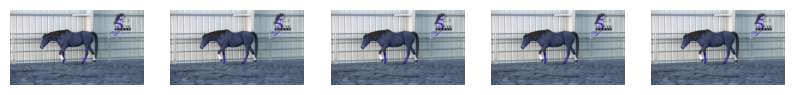

In [5]:
fig, axarr = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
for i in range(len(images)):
    axarr[i].imshow(images[i]) 
    axarr[i].axis('off') 
plt.show()

In [6]:
def homogenize_vectors(tensor, padding_size = 1):
  padded_tensor = torch.nn.functional.pad(
      tensor, pad=(0, padding_size), mode='constant', value=1)
  return padded_tensor

def dehomogenize_vector(tensor, padding_size=1):
  cropped_tensor = tensor[..., :-padding_size]
  return cropped_tensor

## Training Loop

Made base link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made trunk link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made imu_link link's length learnable initialized tensor to tensor([[0., 0., 0.]])
Made FR_hip link's length learnable initialized tensor to tensor([[ 0.181, -0.047,  0.000]])
Made FR_thigh_shoulder link's length learnable initialized tensor to tensor([[ 0.000, -0.081,  0.000]])
Made FR_thigh link's length learnable initialized tensor to tensor([[ 0.000, -0.084,  0.000]])
Made FR_calf link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FR_foot link's length learnable initialized tensor to tensor([[ 0.000,  0.000, -0.200]])
Made FL_hip link's length learnable initialized tensor to tensor([[0.181, 0.047, 0.000]])
Made FL_thigh_shoulder link's length learnable initialized tensor to tensor([[0.000, 0.081, 0.000]])
Made FL_thigh link's length learnable initialized tensor to tensor([[0.000, 0.084, 0.00

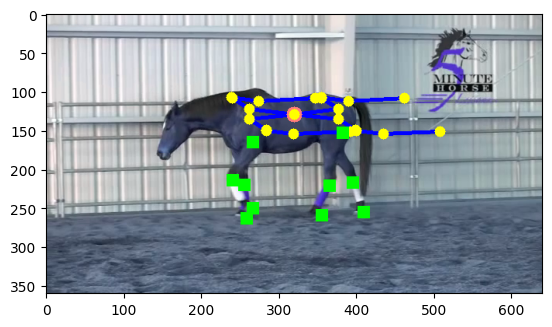

Epoch 10: Loss (5152.7919921875), Loss Per Entry (86.36966705322266 pixels)
Epoch 20: Loss (4584.21923828125), Loss Per Entry (76.88890075683594 pixels)
Epoch 30: Loss (4062.673095703125), Loss Per Entry (68.197509765625 pixels)
Epoch 40: Loss (3601.14892578125), Loss Per Entry (60.51071548461914 pixels)
Epoch 50: Loss (3204.926513671875), Loss Per Entry (53.914852142333984 pixels)
Epoch 60: Loss (2871.459228515625), Loss Per Entry (48.367862701416016 pixels)
Epoch 70: Loss (2556.398193359375), Loss Per Entry (43.13114929199219 pixels)
Epoch 80: Loss (2284.27587890625), Loss Per Entry (38.61172103881836 pixels)
Epoch 90: Loss (2044.81787109375), Loss Per Entry (34.63667297363281 pixels)
Epoch 100: Loss (1807.96923828125), Loss Per Entry (30.705974578857422 pixels)
Epoch 100: Loss (1807.96923828125)


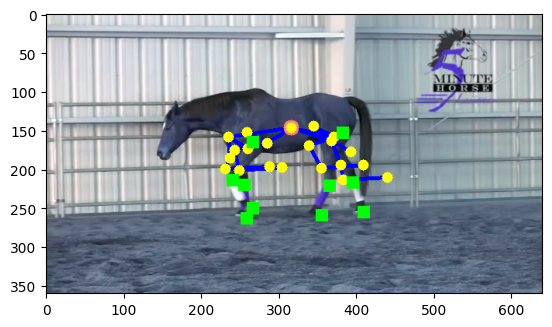

Epoch 110: Loss (1596.458251953125), Loss Per Entry (27.198400497436523 pixels)
Epoch 120: Loss (1494.1871337890625), Loss Per Entry (25.507610321044922 pixels)
Epoch 130: Loss (1428.5328369140625), Loss Per Entry (24.419872283935547 pixels)
Epoch 140: Loss (1360.737060546875), Loss Per Entry (23.293861389160156 pixels)
Epoch 150: Loss (1298.0718994140625), Loss Per Entry (22.25309944152832 pixels)
Epoch 160: Loss (1242.9061279296875), Loss Per Entry (21.339496612548828 pixels)
Epoch 170: Loss (1188.0592041015625), Loss Per Entry (20.432029724121094 pixels)
Epoch 180: Loss (1138.9197998046875), Loss Per Entry (19.619115829467773 pixels)
Epoch 190: Loss (1088.9813232421875), Loss Per Entry (18.793249130249023 pixels)
Epoch 200: Loss (1042.33642578125), Loss Per Entry (18.021833419799805 pixels)
Epoch 200: Loss (1042.33642578125)


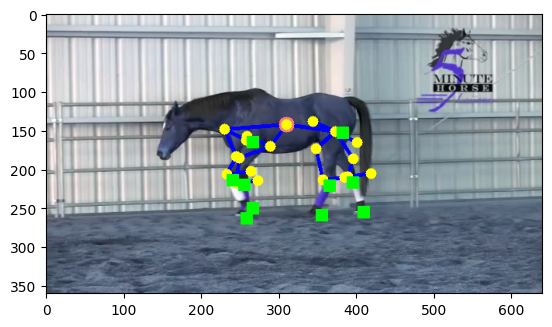

Epoch 210: Loss (997.06396484375), Loss Per Entry (17.273704528808594 pixels)
Epoch 220: Loss (955.8240356445312), Loss Per Entry (16.592430114746094 pixels)
Epoch 230: Loss (917.1736450195312), Loss Per Entry (15.95443058013916 pixels)
Epoch 240: Loss (889.794921875), Loss Per Entry (15.50335693359375 pixels)
Epoch 250: Loss (869.5117797851562), Loss Per Entry (15.168615341186523 pixels)
Epoch 260: Loss (850.0282592773438), Loss Per Entry (14.846553802490234 pixels)
Epoch 270: Loss (832.6214599609375), Loss Per Entry (14.558545112609863 pixels)
Epoch 280: Loss (815.3255004882812), Loss Per Entry (14.272022247314453 pixels)
Epoch 290: Loss (799.8045654296875), Loss Per Entry (14.014787673950195 pixels)
Epoch 300: Loss (783.653076171875), Loss Per Entry (13.746866226196289 pixels)
Epoch 300: Loss (783.653076171875)


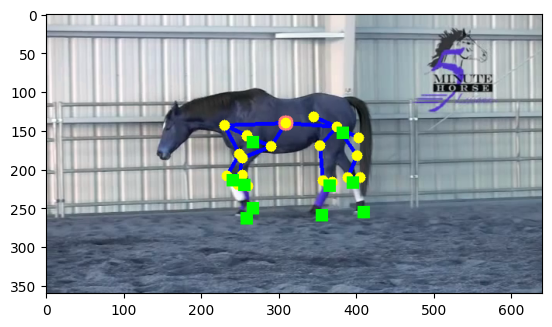

Epoch 310: Loss (767.245361328125), Loss Per Entry (13.474617958068848 pixels)
Epoch 320: Loss (751.452880859375), Loss Per Entry (13.212517738342285 pixels)
Epoch 330: Loss (736.6642456054688), Loss Per Entry (12.967083930969238 pixels)
Epoch 340: Loss (721.3387451171875), Loss Per Entry (12.712725639343262 pixels)
Epoch 350: Loss (706.136962890625), Loss Per Entry (12.46036434173584 pixels)
Epoch 360: Loss (690.5504760742188), Loss Per Entry (12.201495170593262 pixels)
Epoch 370: Loss (675.138427734375), Loss Per Entry (11.945496559143066 pixels)
Epoch 380: Loss (659.8429565429688), Loss Per Entry (11.691407203674316 pixels)
Epoch 390: Loss (644.9404907226562), Loss Per Entry (11.443878173828125 pixels)
Epoch 400: Loss (629.2686767578125), Loss Per Entry (11.183463096618652 pixels)
Epoch 400: Loss (629.2686767578125)


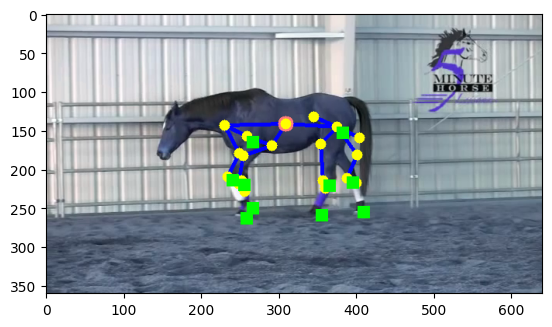

Epoch 410: Loss (614.056884765625), Loss Per Entry (10.930705070495605 pixels)
Epoch 420: Loss (599.0431518554688), Loss Per Entry (10.681227684020996 pixels)
Epoch 430: Loss (584.0755004882812), Loss Per Entry (10.432498931884766 pixels)
Epoch 440: Loss (569.0776977539062), Loss Per Entry (10.183259010314941 pixels)
Epoch 450: Loss (553.96533203125), Loss Per Entry (9.932035446166992 pixels)
Epoch 460: Loss (539.10693359375), Loss Per Entry (9.685060501098633 pixels)
Epoch 470: Loss (524.2738647460938), Loss Per Entry (9.438529014587402 pixels)
Epoch 480: Loss (509.81121826171875), Loss Per Entry (9.198193550109863 pixels)
Epoch 490: Loss (495.55999755859375), Loss Per Entry (8.961661338806152 pixels)
Epoch 500: Loss (482.0427551269531), Loss Per Entry (8.73725700378418 pixels)
Epoch 500: Loss (482.0427551269531)


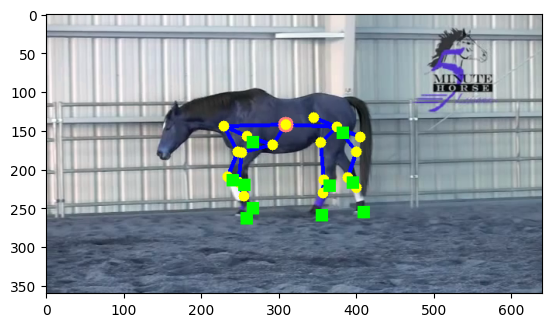

Epoch 510: Loss (467.24462890625), Loss Per Entry (8.491610527038574 pixels)
Epoch 520: Loss (454.39996337890625), Loss Per Entry (8.278779029846191 pixels)
Epoch 530: Loss (441.0137634277344), Loss Per Entry (8.057265281677246 pixels)
Epoch 540: Loss (427.4430847167969), Loss Per Entry (7.832514762878418 pixels)
Epoch 550: Loss (414.5450439453125), Loss Per Entry (7.618765830993652 pixels)
Epoch 560: Loss (402.1766052246094), Loss Per Entry (7.413791179656982 pixels)
Epoch 570: Loss (390.4679260253906), Loss Per Entry (7.220131874084473 pixels)
Epoch 580: Loss (378.7867736816406), Loss Per Entry (7.026954174041748 pixels)
Epoch 590: Loss (367.44940185546875), Loss Per Entry (6.8396992683410645 pixels)
Epoch 600: Loss (356.88104248046875), Loss Per Entry (6.665425777435303 pixels)
Epoch 600: Loss (356.88104248046875)


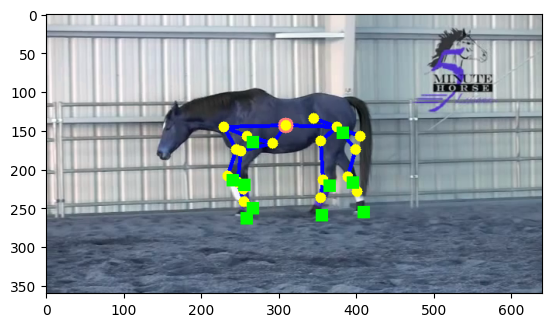

Epoch 610: Loss (345.9490661621094), Loss Per Entry (6.484895706176758 pixels)
Epoch 620: Loss (335.95343017578125), Loss Per Entry (6.319806098937988 pixels)
Epoch 630: Loss (325.568359375), Loss Per Entry (6.148284912109375 pixels)
Epoch 640: Loss (316.3108215332031), Loss Per Entry (5.9955339431762695 pixels)
Epoch 650: Loss (307.07086181640625), Loss Per Entry (5.8428874015808105 pixels)
Epoch 660: Loss (298.69122314453125), Loss Per Entry (5.705179214477539 pixels)
Epoch 670: Loss (290.36962890625), Loss Per Entry (5.568674564361572 pixels)
Epoch 680: Loss (282.06427001953125), Loss Per Entry (5.432034492492676 pixels)
Epoch 690: Loss (274.4360046386719), Loss Per Entry (5.306207180023193 pixels)
Epoch 700: Loss (266.19061279296875), Loss Per Entry (5.170478343963623 pixels)
Epoch 700: Loss (266.19061279296875)


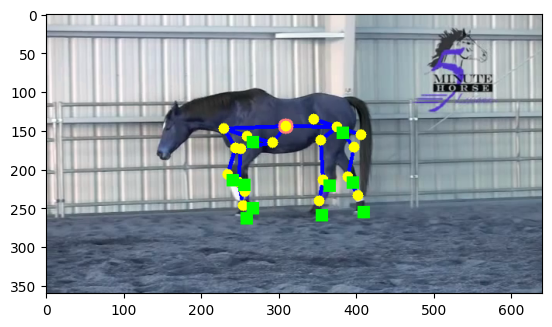

Epoch 710: Loss (258.6907653808594), Loss Per Entry (5.047149181365967 pixels)
Epoch 720: Loss (251.93466186523438), Loss Per Entry (4.93611478805542 pixels)
Epoch 730: Loss (244.85626220703125), Loss Per Entry (4.819632530212402 pixels)
Epoch 740: Loss (238.99020385742188), Loss Per Entry (4.72367000579834 pixels)
Epoch 750: Loss (233.14649963378906), Loss Per Entry (4.6283793449401855 pixels)
Epoch 760: Loss (227.23733520507812), Loss Per Entry (4.531956195831299 pixels)
Epoch 770: Loss (222.30966186523438), Loss Per Entry (4.451448440551758 pixels)
Epoch 780: Loss (216.5623321533203), Loss Per Entry (4.35710334777832 pixels)
Epoch 790: Loss (213.2683868408203), Loss Per Entry (4.303939342498779 pixels)
Epoch 800: Loss (208.4549102783203), Loss Per Entry (4.226181983947754 pixels)
Epoch 800: Loss (208.4549102783203)


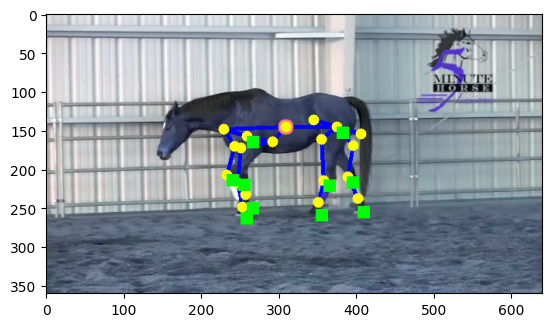

Epoch 810: Loss (202.91639709472656), Loss Per Entry (4.136093616485596 pixels)
Epoch 820: Loss (198.60499572753906), Loss Per Entry (4.065740585327148 pixels)
Epoch 830: Loss (194.5518341064453), Loss Per Entry (3.999610424041748 pixels)
Epoch 840: Loss (190.47584533691406), Loss Per Entry (3.9330291748046875 pixels)
Epoch 850: Loss (188.8717498779297), Loss Per Entry (3.9079127311706543 pixels)
Epoch 860: Loss (183.3412628173828), Loss Per Entry (3.81742262840271 pixels)
Epoch 870: Loss (181.0648193359375), Loss Per Entry (3.780975103378296 pixels)
Epoch 880: Loss (176.8853302001953), Loss Per Entry (3.7127115726470947 pixels)
Epoch 890: Loss (174.64236450195312), Loss Per Entry (3.6766858100891113 pixels)
Epoch 900: Loss (171.42662048339844), Loss Per Entry (3.624492883682251 pixels)
Epoch 900: Loss (171.42662048339844)


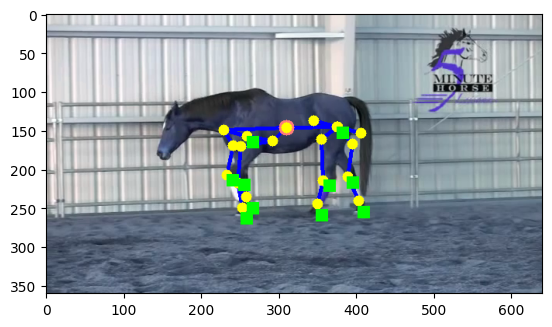

Epoch 910: Loss (168.40431213378906), Loss Per Entry (3.5755369663238525 pixels)
Epoch 920: Loss (165.54415893554688), Loss Per Entry (3.529212474822998 pixels)
Epoch 930: Loss (163.3595428466797), Loss Per Entry (3.4942104816436768 pixels)
Epoch 940: Loss (160.41458129882812), Loss Per Entry (3.446355104446411 pixels)
Epoch 950: Loss (158.83352661132812), Loss Per Entry (3.421196460723877 pixels)
Epoch 960: Loss (155.96514892578125), Loss Per Entry (3.3746469020843506 pixels)
Epoch 970: Loss (154.40284729003906), Loss Per Entry (3.3499596118927 pixels)
Epoch 980: Loss (152.2284698486328), Loss Per Entry (3.3148741722106934 pixels)
Epoch 990: Loss (150.95188903808594), Loss Per Entry (3.294713258743286 pixels)
Epoch 1000: Loss (148.91197204589844), Loss Per Entry (3.2617976665496826 pixels)
Epoch 1000: Loss (148.91197204589844)


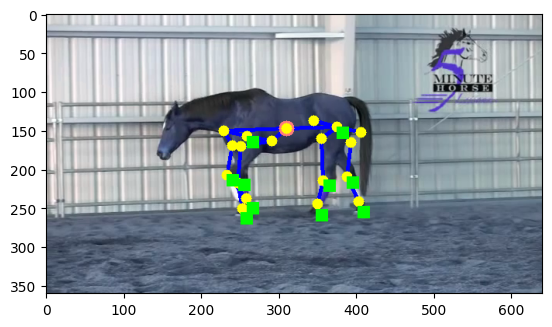

Epoch 1010: Loss (147.29957580566406), Loss Per Entry (3.2360785007476807 pixels)
Epoch 1020: Loss (145.83993530273438), Loss Per Entry (3.212710380554199 pixels)
Epoch 1030: Loss (144.40496826171875), Loss Per Entry (3.189798593521118 pixels)
Epoch 1040: Loss (142.8109893798828), Loss Per Entry (3.164318084716797 pixels)
Epoch 1050: Loss (142.2346954345703), Loss Per Entry (3.155834913253784 pixels)
Epoch 1060: Loss (141.08973693847656), Loss Per Entry (3.1377134323120117 pixels)
Epoch 1070: Loss (138.97354125976562), Loss Per Entry (3.1034460067749023 pixels)
Epoch 1080: Loss (138.4994354248047), Loss Per Entry (3.096421480178833 pixels)
Epoch 1090: Loss (137.10894775390625), Loss Per Entry (3.07415771484375 pixels)
Epoch 1100: Loss (136.1791229248047), Loss Per Entry (3.0594863891601562 pixels)
Epoch 1100: Loss (136.1791229248047)


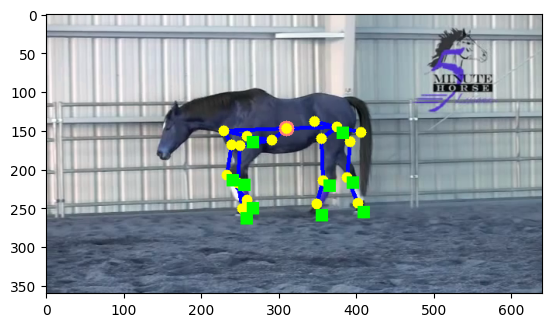

Epoch 1110: Loss (135.2233428955078), Loss Per Entry (3.0444488525390625 pixels)
Epoch 1120: Loss (134.3507843017578), Loss Per Entry (3.030863046646118 pixels)
Epoch 1130: Loss (132.75567626953125), Loss Per Entry (3.005037546157837 pixels)
Epoch 1140: Loss (132.45030212402344), Loss Per Entry (3.0006332397460938 pixels)
Epoch 1150: Loss (131.32504272460938), Loss Per Entry (2.9825403690338135 pixels)
Epoch 1160: Loss (131.2920684814453), Loss Per Entry (2.9827935695648193 pixels)
Epoch 1170: Loss (130.60165405273438), Loss Per Entry (2.972080945968628 pixels)
Epoch 1180: Loss (130.01699829101562), Loss Per Entry (2.9630472660064697 pixels)
Epoch 1190: Loss (128.49539184570312), Loss Per Entry (2.9383513927459717 pixels)
Epoch 1200: Loss (128.17190551757812), Loss Per Entry (2.9335312843322754 pixels)
Epoch 1200: Loss (128.17190551757812)


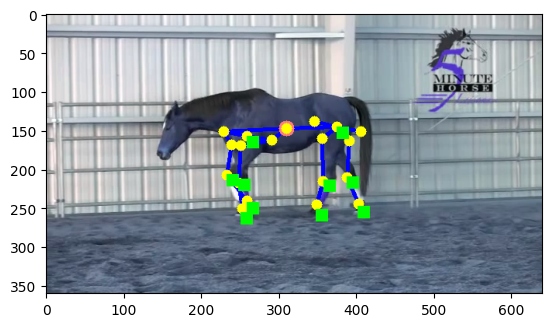

Epoch 1210: Loss (127.54100799560547), Loss Per Entry (2.9235808849334717 pixels)
Epoch 1220: Loss (127.15907287597656), Loss Per Entry (2.9177486896514893 pixels)
Epoch 1230: Loss (126.74186706542969), Loss Per Entry (2.911417245864868 pixels)
Epoch 1240: Loss (125.97258758544922), Loss Per Entry (2.8992199897766113 pixels)
Epoch 1250: Loss (125.49806213378906), Loss Per Entry (2.8918752670288086 pixels)
Epoch 1260: Loss (124.70703125), Loss Per Entry (2.8791472911834717 pixels)
Epoch 1270: Loss (124.28512573242188), Loss Per Entry (2.8725454807281494 pixels)
Epoch 1280: Loss (124.60453033447266), Loss Per Entry (2.8782196044921875 pixels)
Epoch 1290: Loss (122.98978424072266), Loss Per Entry (2.851696014404297 pixels)
Epoch 1300: Loss (123.62056732177734), Loss Per Entry (2.8625423908233643 pixels)
Epoch 1300: Loss (123.62056732177734)


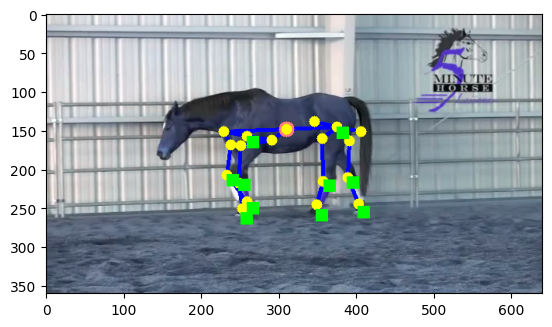

Epoch 1310: Loss (123.41622924804688), Loss Per Entry (2.8594939708709717 pixels)
Epoch 1320: Loss (122.17556762695312), Loss Per Entry (2.839244842529297 pixels)
Epoch 1330: Loss (123.80905151367188), Loss Per Entry (2.8668720722198486 pixels)
Epoch 1340: Loss (122.03480529785156), Loss Per Entry (2.837798595428467 pixels)
Epoch 1350: Loss (121.59882354736328), Loss Per Entry (2.8310062885284424 pixels)
Epoch 1360: Loss (120.34274291992188), Loss Per Entry (2.8103437423706055 pixels)
Epoch 1370: Loss (120.28353118896484), Loss Per Entry (2.8096814155578613 pixels)
Epoch 1380: Loss (119.93006134033203), Loss Per Entry (2.8040502071380615 pixels)
Epoch 1390: Loss (119.29740142822266), Loss Per Entry (2.7936742305755615 pixels)
Epoch 1400: Loss (119.23179626464844), Loss Per Entry (2.7927634716033936 pixels)
Epoch 1400: Loss (119.23179626464844)


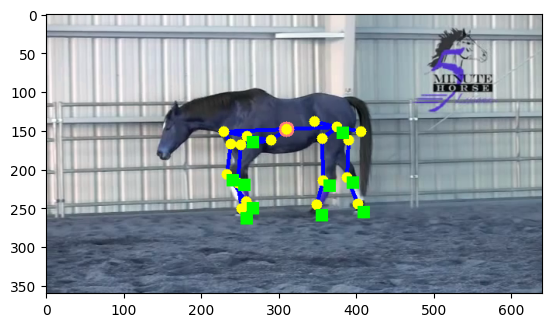

Epoch 1410: Loss (119.00566864013672), Loss Per Entry (2.789220094680786 pixels)
Epoch 1420: Loss (119.36846160888672), Loss Per Entry (2.795548439025879 pixels)
Epoch 1430: Loss (119.51140594482422), Loss Per Entry (2.798283815383911 pixels)
Epoch 1440: Loss (119.5189208984375), Loss Per Entry (2.7988553047180176 pixels)
Epoch 1450: Loss (119.39313507080078), Loss Per Entry (2.7971954345703125 pixels)
Epoch 1460: Loss (118.5509033203125), Loss Per Entry (2.783358335494995 pixels)
Epoch 1470: Loss (117.90174865722656), Loss Per Entry (2.77276873588562 pixels)
Epoch 1480: Loss (117.87632751464844), Loss Per Entry (2.7725625038146973 pixels)
Epoch 1490: Loss (117.4800033569336), Loss Per Entry (2.7661423683166504 pixels)
Epoch 1500: Loss (117.56681060791016), Loss Per Entry (2.7677114009857178 pixels)
Epoch 1500: Loss (117.56681060791016)


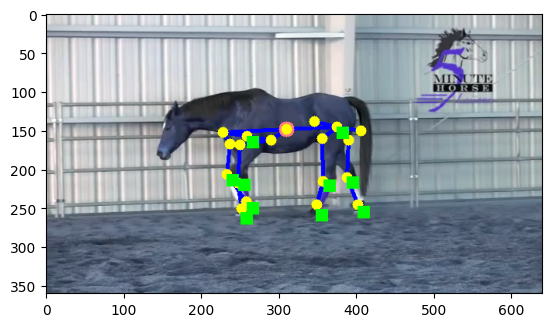

Epoch 1510: Loss (118.65726470947266), Loss Per Entry (2.7861037254333496 pixels)
Epoch 1520: Loss (118.65227508544922), Loss Per Entry (2.7862517833709717 pixels)
Epoch 1530: Loss (118.02469635009766), Loss Per Entry (2.7761175632476807 pixels)
Epoch 1540: Loss (117.65190887451172), Loss Per Entry (2.770097255706787 pixels)
Epoch 1550: Loss (116.963623046875), Loss Per Entry (2.7587966918945312 pixels)
Epoch 1560: Loss (116.78057861328125), Loss Per Entry (2.755884885787964 pixels)
Epoch 1570: Loss (116.69302368164062), Loss Per Entry (2.754558563232422 pixels)
Epoch 1580: Loss (118.07221984863281), Loss Per Entry (2.77760910987854 pixels)
Epoch 1590: Loss (116.91690826416016), Loss Per Entry (2.7585268020629883 pixels)
Epoch 1600: Loss (116.20948028564453), Loss Per Entry (2.7468063831329346 pixels)
Epoch 1600: Loss (116.20948028564453)


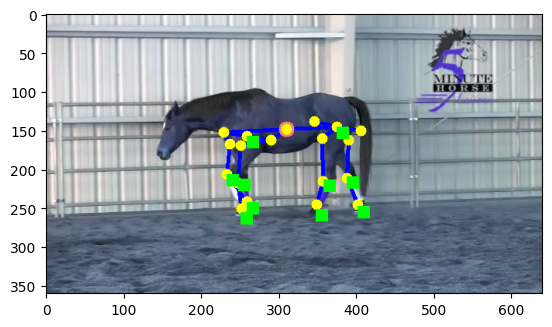

Epoch 1610: Loss (116.09880828857422), Loss Per Entry (2.7450647354125977 pixels)
Epoch 1620: Loss (117.33716583251953), Loss Per Entry (2.765845775604248 pixels)
Epoch 1630: Loss (116.68570709228516), Loss Per Entry (2.7551486492156982 pixels)
Epoch 1640: Loss (115.23255157470703), Loss Per Entry (2.7310211658477783 pixels)
Epoch 1650: Loss (114.81975555419922), Loss Per Entry (2.724243402481079 pixels)
Epoch 1660: Loss (116.66107177734375), Loss Per Entry (2.75504732131958 pixels)
Epoch 1670: Loss (115.27993774414062), Loss Per Entry (2.7321038246154785 pixels)
Epoch 1680: Loss (115.61813354492188), Loss Per Entry (2.7378315925598145 pixels)
Epoch 1690: Loss (115.19271850585938), Loss Per Entry (2.730837345123291 pixels)
Epoch 1700: Loss (115.6424331665039), Loss Per Entry (2.7383105754852295 pixels)
Epoch 1700: Loss (115.6424331665039)


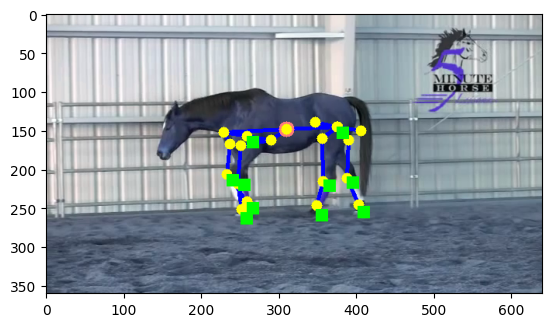

Epoch 1710: Loss (116.2797622680664), Loss Per Entry (2.7490828037261963 pixels)
Epoch 1720: Loss (115.5807876586914), Loss Per Entry (2.7375237941741943 pixels)
Epoch 1730: Loss (117.27580261230469), Loss Per Entry (2.765866994857788 pixels)
Epoch 1740: Loss (115.27407836914062), Loss Per Entry (2.7326035499572754 pixels)
Epoch 1750: Loss (115.37825012207031), Loss Per Entry (2.734300136566162 pixels)
Epoch 1760: Loss (115.73255920410156), Loss Per Entry (2.7402238845825195 pixels)
Epoch 1770: Loss (115.68769836425781), Loss Per Entry (2.7396390438079834 pixels)
Epoch 1780: Loss (115.96711730957031), Loss Per Entry (2.744215488433838 pixels)
Epoch 1790: Loss (116.09663391113281), Loss Per Entry (2.746368169784546 pixels)
Epoch 1800: Loss (115.41913604736328), Loss Per Entry (2.7350590229034424 pixels)
Epoch 1800: Loss (115.41913604736328)


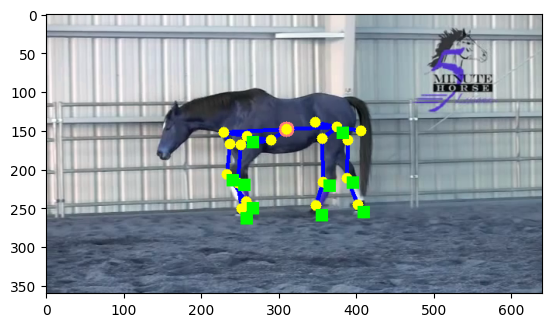

Epoch 1810: Loss (116.44430541992188), Loss Per Entry (2.752159833908081 pixels)
Epoch 1820: Loss (115.93998718261719), Loss Per Entry (2.7437446117401123 pixels)
Epoch 1830: Loss (115.63060760498047), Loss Per Entry (2.738574743270874 pixels)
Epoch 1840: Loss (115.46922302246094), Loss Per Entry (2.7359325885772705 pixels)
Epoch 1850: Loss (114.76033782958984), Loss Per Entry (2.7241201400756836 pixels)
Epoch 1860: Loss (114.8823471069336), Loss Per Entry (2.726165294647217 pixels)
Epoch 1870: Loss (114.28865051269531), Loss Per Entry (2.7162606716156006 pixels)
Epoch 1880: Loss (116.30995178222656), Loss Per Entry (2.749920606613159 pixels)
Epoch 1890: Loss (114.30108642578125), Loss Per Entry (2.716449022293091 pixels)
Epoch 1900: Loss (114.30203247070312), Loss Per Entry (2.71642804145813 pixels)
Epoch 1900: Loss (114.30203247070312)


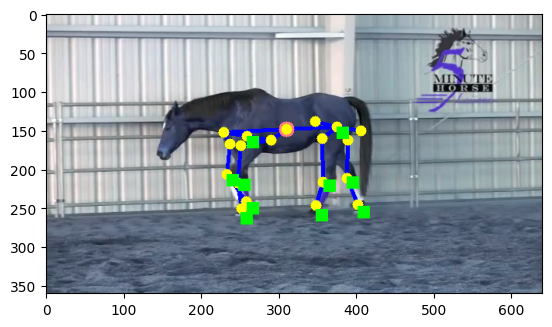

Epoch 1910: Loss (114.57503509521484), Loss Per Entry (2.7209084033966064 pixels)
Epoch 1920: Loss (114.9819564819336), Loss Per Entry (2.727705955505371 pixels)
Epoch 1930: Loss (114.24252319335938), Loss Per Entry (2.715359926223755 pixels)
Epoch 1940: Loss (115.49906921386719), Loss Per Entry (2.7363407611846924 pixels)
Epoch 1950: Loss (113.63819885253906), Loss Per Entry (2.705327272415161 pixels)
Epoch 1960: Loss (113.90174865722656), Loss Per Entry (2.7096517086029053 pixels)
Epoch 1970: Loss (113.28887176513672), Loss Per Entry (2.699397563934326 pixels)
Epoch 1980: Loss (113.73575592041016), Loss Per Entry (2.706836223602295 pixels)
Epoch 1990: Loss (113.97396850585938), Loss Per Entry (2.7107746601104736 pixels)


In [7]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]

#Resets robot limb lengths to those from URDF
for joint in intialJointAngles:
    makeLinkLengthLearnable(joint, intialJointAngles[joint].detach().clone())

init_angles = torch.ones((12,))
init_angles = init_angles.repeat(imgCount,1)
joint_angles = init_angles.requires_grad_(True)

constantTensor = lambda constant: torch.tensor(float(constant))
differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)

fx = differentiableConstantTensor(-320)
fy  = differentiableConstantTensor(130)
u0 = differentiableConstantTensor(320)
v0 = differentiableConstantTensor(130)



tx = torch.ones((imgCount,))*0
tx = tx.requires_grad_(True)
ty = torch.ones((imgCount,))*0
ty = ty.requires_grad_(True)
tz = torch.ones((imgCount,))*1
tz = tz.requires_grad_(True)

#Zero rotation quaternion
#Good visualization resource: https://quaternions.online
extrinsicRotationQuaternion = torch.tensor([1.0, 0.0,  0.0, 0.0])
extrinsicRotationQuaternion = extrinsicRotationQuaternion.unsqueeze(0) * torch.ones((imgCount,4))
extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(True)

%matplotlib inline
VERBOSE = True
optimizer = torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles]+ list(learnable_robot_model.parameters()), lr=1e-3)
#optimizer = torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles], lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
robotEEPositions = None
trainingFrames = []
for epoch in range(2*1000):
    optimizer.zero_grad()
    intrinsic = torch.vstack([
        torch.hstack([fx,constantTensor(0), u0]),
        torch.hstack([constantTensor(0),fy, v0]),
        torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
    ])

    formatTensor = torch.tensor([1.0,0.0,0.0])
    xComponent = tx.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,1.0,0.0])
    yComponent = ty.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,0.0,1.0])
    zComponent = tz.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))

    extriniscTransformation = xComponent + yComponent + zComponent
    extrinsicRotation = pytorch3d.transforms.quaternion_to_matrix(extrinsicRotationQuaternion)
    extriniscTransformation = extriniscTransformation.reshape(imgCount,3,1)
    extrinsic = torch.cat((extrinsicRotation, extriniscTransformation),2)
    
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    #If Only One Entry Duplicate Data
    for jointName in robotEEPositions:
        if robotEEPositions[jointName].shape[0] == imgCount:
            continue
        robotEEPositions[jointName] = robotEEPositions[jointName].repeat(imgCount,1)
    jointPosition = torch.hstack([robotEEPositions[joint].unsqueeze(1) for joint in robot_joints_for_training])
    def calculateCameraProjection(intrinsic, extrinsic, jointPositions):
        transform = intrinsic@extrinsic
        pixelPositions = transform@(homogenize_vectors(jointPositions).transpose(1,2))
        pixelPositions = pixelPositions.transpose(1,2)
        pixelPositions = dehomogenize_vector(pixelPositions)
        return pixelPositions
    jointCameraPositions = calculateCameraProjection(intrinsic, extrinsic, jointPosition)
    pixelLoss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions.reshape(-1,2) - ((training_data).reshape(-1,2)), 2),-1)))

    def interframeJointLoss(jointAngles):
        """
            The L2 norm computed for every joint. Measures frame by frame the changes in joint angles, to minimze it
        """
        return torch.sum(torch.sqrt(torch.sum(torch.pow(jointAngles[1:] - jointAngles[:-1],2), -1)))
    #Experimentally Ive seen it ranges it has a magnitude in the e-1's
    jointLoss = interframeJointLoss(joint_angles)

    def totalLimbLength():
        """
            Returns the length of all of the links of the robot
        """
        robotLinks = torch.vstack([learnable_robot_model._get_parent_object_of_param(joint, "trans").trans().detach().clone() for joint in learnable_robot_model.get_link_names()])
        return torch.sum(torch.sqrt(torch.sum(torch.pow(robotLinks,2),-1)))
    limbLengthLoss = totalLimbLength()

    loss = pixelLoss + 10*limbLengthLoss# + jointLoss

    n = 10
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({pixelLoss}), Loss Per Entry ({loss/jointCameraPositions.reshape(-1,2).shape[0]} pixels)")
    n = 100
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({pixelLoss})")
        img = (images[0]).copy()
        positionByJoint = torch.cat([v[0].unsqueeze(0) if len(v.shape) >= 2 else v.unsqueeze(0) for v in robotEEPositions.values()])
        #
        allJointPosiitons = calculateCameraProjection(intrinsic, extrinsic, positionByJoint.unsqueeze(0).repeat(imgCount,1,1))[0]
        jointToCameraPosition = {key:allJointPosiitons[index] for index,key in enumerate(robotEEPositions)}
        size = 15
        #Draw Robot Links
        for line in links:
            start,end = line[0], line[1]
            start, end = jointToCameraPosition[start], jointToCameraPosition[end]
            start = tuple(start.clone().detach().numpy())
            end = tuple(end.clone().detach().numpy())
            start = tuple((int(i) for i in start))
            end = tuple((int(i) for i in end))
            img = cv2.line(img,start, end, (0,0,255),size//4)
        #Draw Robot Joints
        for joint in jointToCameraPosition:
            jointPositionTensor = jointToCameraPosition[joint]
            color = (255,255,0)
            dotSize = size//2
            if joint == "base":
                color = (255,124,124)
                dotSize = int(dotSize*1.5)
            jointPosition = jointPositionTensor.clone().detach().numpy()
            x,y = tuple((int(i) for i in jointPosition))
            img = cv2.circle(img,(x, y),dotSize,color,-1)
        #Draw Keypoints
        for x,y in training_data[0]:
            color = (0,255,0)
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        trainingFrames.append(img)
        plt.clf()
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()
    